In [32]:
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline

In [33]:
class Value:
    def __init__(self, data, children=(), op='', label=''):
        self.data = data
        self._prev = set(children)
        self._op = op
        self.label = label
        self.grad = 0.
        self._backward = lambda:None
    
    def __repr__(self):
        return f"Value=(data={self.data})"
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        return out
    
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data+other.data, (self, other), op='+')
        def _backward():
            self.grad += 1.*out.grad
            other.grad += 1.*out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data*other.data, (self, other), op='*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (float, int))
        out = Value(self.data**other, (self,), op=f'**{other}')
        def _backward():
            self.grad += other * (1-self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
        
    def __truediv__(self, other):
        return self * other**-1
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), op='exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build(n):
            if n not in visited:
                visited.add(n)
                for child in n._prev:
                    build(child)
                topo.append(n)
        build(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()        

In [34]:
from graphviz import Digraph

def build_trace(root):
    nodes,edges = set(),set()
    def build(n):
        if n not in nodes:
            nodes.add(n)
            for child in n._prev:
                edges.add((child, n))
                build(child)
    build(root)
    return nodes, edges

In [35]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes,edges = build_trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [36]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label ='x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
o.backward()

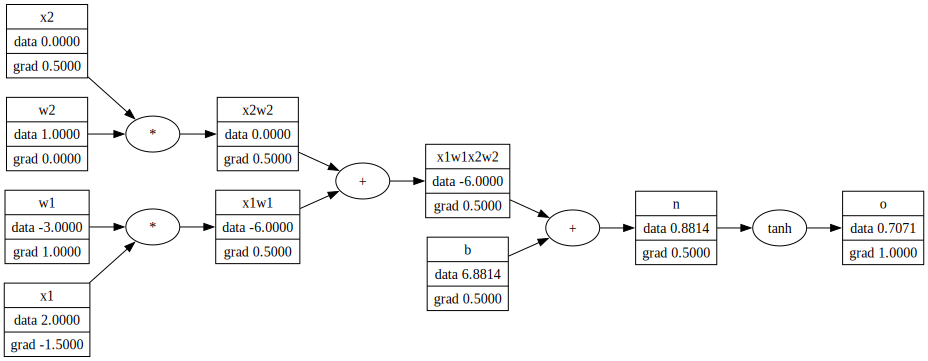

In [37]:
draw_dot(o)

In [38]:
import torch

In [52]:
x1 = torch.tensor(2.0).double(); x1.requires_grad = True
x2 = torch.tensor(0.0).double(); x2.requires_grad = True

w1 = torch.tensor(-3.0).double(); w1.requires_grad = True
w2 = torch.tensor(1.0).double(); w2.requires_grad  = True

b = torch.tensor(6.8813735870195432).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('------------')
print('x1', x1.grad)
print('x2', x2.grad)
print('w1', w1.grad)
print('w2', w2.grad)

0.7071066904050358
------------
x1 tensor(-1.5000, dtype=torch.float64)
x2 tensor(0.5000, dtype=torch.float64)
w1 tensor(1.0000, dtype=torch.float64)
w2 tensor(0., dtype=torch.float64)


In [62]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [63]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out)==1 else out
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [64]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [68]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value=(data=0.6297629549622082)